# Suraksha Setu — Advanced Multi-Hazard Models (Optuna + SMOTE + Feature Importance)

**This notebook includes**:
- Data loading for Flood, Landslide, and Forest Fire cleaned CSVs
- Preprocessing and feature engineering
- Class imbalance handling with SMOTE
- Model training with hyperparameter tuning using Optuna
  - Flood: LSTM (Keras) with Optuna tuner-like loop
  - Landslide: XGBoost with Optuna tuning
  - Forest Fire: CNN-LSTM with Optuna tuning
- Model saving (`.h5`, `.joblib`, `.json`)
- Stacking ensemble (XGBoost meta-model)
- Evaluation: ROC, Precision-Recall, confusion matrices, calibration, and feature importance
- Notes: Align time/spatial indices before real-world stacking


In [2]:
!pip install optuna

  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.2 MB/s eta 0:00:00


In [3]:
# Install required packages (uncomment if running in Colab)
!pip install xgboost tensorflow scikit-learn pandas numpy matplotlib seaborn joblib imbalanced-learn optuna tensorflow-addons

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print('Libraries loaded')

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons
Libraries loaded


In [4]:
# Paths - update if needed
FLOOD_PATH = '/content/flood_cleaned.csv'
LANDSLIDE_PATH = '/content/Landslide_Factors_cleaned.csv'
FIRE_PATH = '/content/forestfires_cleaned.csv'
OUTPUT_DIR = '/content/sample_data/suraksha_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('OUTPUT_DIR =', OUTPUT_DIR)

OUTPUT_DIR = /content/sample_data/suraksha_models


In [5]:
# Utility functions
from sklearn.calibration import calibration_curve
def print_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)
    print(f'Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | AUC: {auc:.3f} | AP: {ap:.3f}')
    return {'accuracy':acc,'precision':prec,'recall':rec,'f1':f1,'auc':auc,'ap':ap}

def plot_roc_pr(y_true, y_scores, label='Model'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'{label} (AUC={auc:.3f})')
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'{label} (AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.legend()
    plt.show()

def save_keras_model(model, path):
    model.save(path)
    print('Saved Keras model to', path)

def save_joblib(obj, path):
    joblib.dump(obj, path)
    print('Saved joblib object to', path)

def plot_calibration(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel('Predicted probability'); plt.ylabel('True probability'); plt.title('Calibration curve')
    plt.show()

In [6]:
# Load datasets
df_flood = pd.read_csv(FLOOD_PATH)
df_land = pd.read_csv(LANDSLIDE_PATH)
df_fire = pd.read_csv(FIRE_PATH)
print('Flood:', df_flood.shape, 'Landslide:', df_land.shape, 'Fire:', df_fire.shape)

Flood: (50000, 21) Landslide: (4295, 15) Fire: (517, 13)


In [7]:
# Flood preprocessing: prepare sequences and apply SMOTE at sequence-level via aggregated features
df = df_flood.copy()
# detect time and target
time_col = next((c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()), None)
target_col = next((c for c in df.columns if c.lower() in ['risk','risk_score','target','label','flood_risk']), None)
if time_col: df[time_col] = pd.to_datetime(df[time_col], errors='coerce'); df = df.sort_values(time_col)
num_feats = df.select_dtypes(include='number').columns.tolist()
if target_col in num_feats: num_feats.remove(target_col)
print('Using numeric features:', num_feats)
# fill missing and scale
df[num_feats] = df[num_feats].fillna(df[num_feats].median())
scaler_flood = MinMaxScaler()
X_num = scaler_flood.fit_transform(df[num_feats])
save_joblib(scaler_flood, os.path.join(OUTPUT_DIR,'flood_scaler.joblib'))

# create rolling-window aggregates for SMOTE (since SMOTE on sequences is complex)
WINDOW = 24
agg_features = []
for i in range(WINDOW, len(df)):
    window = X_num[i-WINDOW:i]
    agg = np.concatenate([window.mean(axis=0), window.std(axis=0), window.min(axis=0), window.max(axis=0)])
    agg_features.append(agg)
agg_features = np.array(agg_features)
y = df[target_col].fillna(0).values[WINDOW:] if target_col else (agg_features[:,0] > np.percentile(agg_features[:,0],90)).astype(int)

print('Aggregated features shape for SMOTE:', agg_features.shape, 'y shape:', y.shape)
sm = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = sm.fit_resample(agg_features, y)
print('After SMOTE:', X_res.shape, y_res.sum(), 'positive samples')

# Convert back to sequences by sampling from resampled aggregates - we'll build sequences by matching nearest aggregate index (approximation)
# For simplicity for training LSTM, we'll use the original sequences (without SMOTE) but use class weights computed from y_res
from collections import Counter
class_weights = {0: (len(y_res)/(2*Counter(y_res)[0])), 1: (len(y_res)/(2*Counter(y_res)[1]))}
print('Class weights for flood LSTM:', class_weights)

# Build actual sequences (original)
SEQ_LEN = 24
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X)-seq_len):
        Xs.append(X[i:(i+seq_len)])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_num, df[target_col].fillna(0).values if target_col else (X_num[:,0] > np.percentile(X_num[:,0],90)).astype(int), SEQ_LEN)
split_idx = int(0.8 * len(X_seq))
X_train_flood, X_test_flood = X_seq[:split_idx], X_seq[split_idx:]
y_train_flood, y_test_flood = y_seq[:split_idx], y_seq[split_idx:]
print('Flood sequences:', X_train_flood.shape, y_train_flood.sum(), 'positives in train')

Using numeric features: ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors', 'FloodProbability']
Saved joblib object to /content/sample_data/suraksha_models/flood_scaler.joblib
Aggregated features shape for SMOTE: (49976, 84) y shape: (49976,)
After SMOTE: (90562, 84) 45281 positive samples
Class weights for flood LSTM: {0: 1.0, 1: 1.0}
Flood sequences: (39980, 24, 21) 2705 positives in train


[I 2025-11-10 20:30:40,127] A new study created in memory with name: no-name-ba4a197c-b633-467a-9435-818ad25ca022


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


[I 2025-11-10 20:32:03,185] Trial 0 finished with value: 0.5109614689252067 and parameters: {'units1': 64, 'units2': 16, 'dropout': 0.11742508365045984, 'lr': 0.005399484409787433, 'batch_size': 64}. Best is trial 0 with value: 0.5109614689252067.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


[I 2025-11-10 20:33:10,586] Trial 1 finished with value: 0.508436783527439 and parameters: {'units1': 32, 'units2': 64, 'dropout': 0.2574269294896714, 'lr': 0.0007309539835912913, 'batch_size': 64}. Best is trial 0 with value: 0.5109614689252067.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2025-11-10 20:36:19,550] Trial 2 finished with value: 0.5064925476919899 and parameters: {'units1': 128, 'units2': 16, 'dropout': 0.2777243706586128, 'lr': 0.0001238513729886094, 'batch_size': 32}. Best is trial 0 with value: 0.5109614689252067.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


[I 2025-11-10 20:37:23,188] Trial 3 finished with value: 0.5112733890418688 and parameters: {'units1': 64, 'units2': 64, 'dropout': 0.23204574812188042, 'lr': 0.00017541893487450815, 'batch_size': 128}. Best is trial 3 with value: 0.5112733890418688.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2025-11-10 20:40:46,517] Trial 4 finished with value: 0.48237846042588023 and parameters: {'units1': 64, 'units2': 32, 'dropout': 0.39087538832936763, 'lr': 0.0035503048581283078, 'batch_size': 32}. Best is trial 3 with value: 0.5112733890418688.


Best LSTM trial: {'units1': 64, 'units2': 64, 'dropout': 0.23204574812188042, 'lr': 0.00017541893487450815, 'batch_size': 128} AUC: 0.5112733890418688
Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.5032 - loss: 0.3443 - val_AUC: 0.4766 - val_loss: 0.2467
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - AUC: 0.5152 - loss: 0.2525 - val_AUC: 0.4947 - val_loss: 0.2467
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - AUC: 0.5045 - loss: 0.2528 - val_AUC: 0.4925 - val_loss: 0.2466
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.4930 - loss: 0.2536 - val_AUC: 0.5126 - val_loss: 0.2466
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.4952 - loss: 0.2536 - val_AUC: 0.5071 - val_loss: 0.2466
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - AUC: 0.4968 - loss: 0.2532 - val_AUC: 0.5085 - val_loss: 0.2466
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.5105 - loss: 0.2518 - val_AUC: 0.4786 - val_loss: 0.2466
Epoch 8/50
282/2

Saved Keras model to /content/sample_data/suraksha_models/flood_lstm_opt.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.932 | Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.496 | AP: 0.068


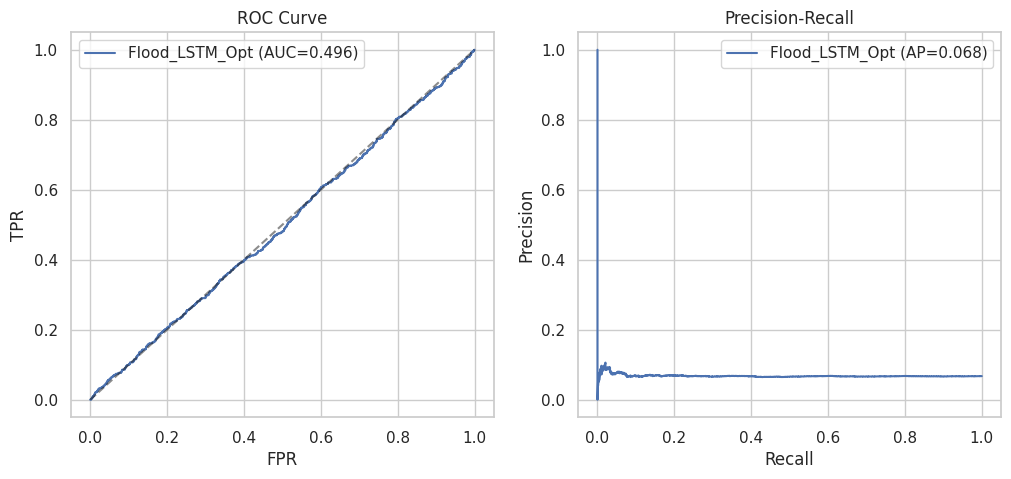

In [9]:
# Optuna objective for LSTM (search over units, dropout, lr)
import optuna, math, tempfile
def build_lstm(trial, input_shape):
    units1 = trial.suggest_categorical('units1', [32,64,128])
    units2 = trial.suggest_categorical('units2', [16,32,64])
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    inp = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(units1, return_sequences=True))(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Bidirectional(layers.LSTM(units2))(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['AUC'])
    return model

def objective_lstm(trial):
    tf.keras.backend.clear_session()
    model = build_lstm(trial, (X_train_flood.shape[1], X_train_flood.shape[2]))
    batch = trial.suggest_categorical('batch_size', [32,64,128])
    epochs = 30
    history = model.fit(X_train_flood, y_train_flood, validation_split=0.1, epochs=epochs, batch_size=batch, class_weight=class_weights, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
    preds = model.predict(X_test_flood).ravel()
    auc = roc_auc_score(y_test_flood, preds)
    # save intermediate best model
    return auc

study_lstm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_lstm.optimize(objective_lstm, n_trials=5)  # adjust n_trials as compute allows
print('Best LSTM trial:', study_lstm.best_params, 'AUC:', study_lstm.best_value)

# Build final model with best params and save
best_params = study_lstm.best_params
final_model = build_lstm(optuna.trial.FixedTrial(best_params), (X_train_flood.shape[1], X_train_flood.shape[2]))
final_model.fit(X_train_flood, y_train_flood, validation_split=0.1, epochs=50, batch_size=best_params.get('batch_size',64), class_weight=class_weights, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
save_keras_model(final_model, os.path.join(OUTPUT_DIR, 'flood_lstm_opt.h5'))
y_pred_prob_lstm = final_model.predict(X_test_flood).ravel()
metrics_lstm = print_metrics(y_test_flood, y_pred_prob_lstm)
plot_roc_pr(y_test_flood, y_pred_prob_lstm, label='Flood_LSTM_Opt')

In [10]:
# Landslide preprocessing with SMOTE and feature scaling
df = df_land.copy()
target_col = next((c for c in df.columns if c.lower() in ['target','label','landslide','landslide_risk','susceptible']), None)
if target_col is None:
    # create proxy target
    num_cols = df.select_dtypes(include='number').columns.tolist()
    target_col = 'target'
    df[target_col] = (df[num_cols[0]] > np.percentile(df[num_cols[0]],90)).astype(int)
print('Target column for landslide:', target_col)
# Drop columns with too many missing
df = df.loc[:, df.isnull().mean() < 0.4]
num_cols = df.select_dtypes(include='number').columns.tolist()
if target_col in num_cols: num_cols.remove(target_col)
cat_cols = df.select_dtypes(include='object').columns.tolist()
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    df[c].fillna('NA', inplace=True); df[c] = LabelEncoder().fit_transform(df[c].astype(str))
X = df[num_cols]; y = df[target_col].astype(int)
scaler_land = StandardScaler()
X_scaled = scaler_land.fit_transform(X)
save_joblib(scaler_land, os.path.join(OUTPUT_DIR,'land_scaler.joblib'))
sm = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = sm.fit_resample(X_scaled, y)
print('After SMOTE:', X_res.shape, 'Positives:', y_res.sum())
X_train_land, X_test_land, y_train_land, y_test_land = train_test_split(X_res, y_res, test_size=0.2, random_state=RANDOM_SEED, stratify=y_res)

Target column for landslide: target
Saved joblib object to /content/sample_data/suraksha_models/land_scaler.joblib
After SMOTE: (7730, 11) Positives: 3865


🔍 Detected XGBoost version: 3.1.1


[I 2025-11-10 20:46:02,326] A new study created in memory with name: no-name-24c16e80-1b19-49bc-81ae-4bbb10b5e386


⚙️ GPU Support Available: False


[I 2025-11-10 20:46:02,786] Trial 0 finished with value: 1.0 and parameters: {'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.839196365086843, 'subsample': 0.759195090518222, 'learning_rate': 0.00029380279387035364, 'n_estimators': 120, 'max_depth': 3, 'min_child_weight': 9}. Best is trial 0 with value: 1.0.
[I 2025-11-10 20:46:03,228] Trial 1 finished with value: 0.9999999999999999 and parameters: {'lambda': 0.2537815508265665, 'alpha': 0.679657809075816, 'colsample_bytree': 0.41235069657748147, 'subsample': 0.9819459112971965, 'learning_rate': 0.03142880890840111, 'n_estimators': 145, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 0 with value: 1.0.
[I 2025-11-10 20:46:03,475] Trial 2 finished with value: 1.0 and parameters: {'lambda': 0.016480446427978974, 'alpha': 0.12561043700013558, 'colsample_bytree': 0.6591670111852694, 'subsample': 0.5747374841188252, 'learning_rate': 0.006847920095574782, 'n_estimators': 112, 'max_depth': 5, 'min_child_

✅ Best XGB params: {'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.839196365086843, 'subsample': 0.759195090518222, 'learning_rate': 0.00029380279387035364, 'n_estimators': 120, 'max_depth': 3, 'min_child_weight': 9}
🏆 Best validation AUC: 1.0
Saved joblib object to /content/sample_data/suraksha_models/landslide_xgb.joblib


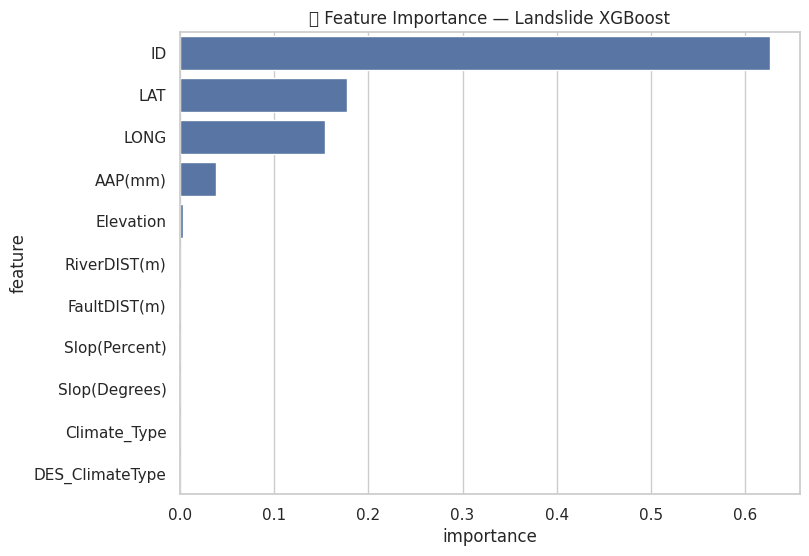

Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | AUC: 1.000 | AP: 1.000


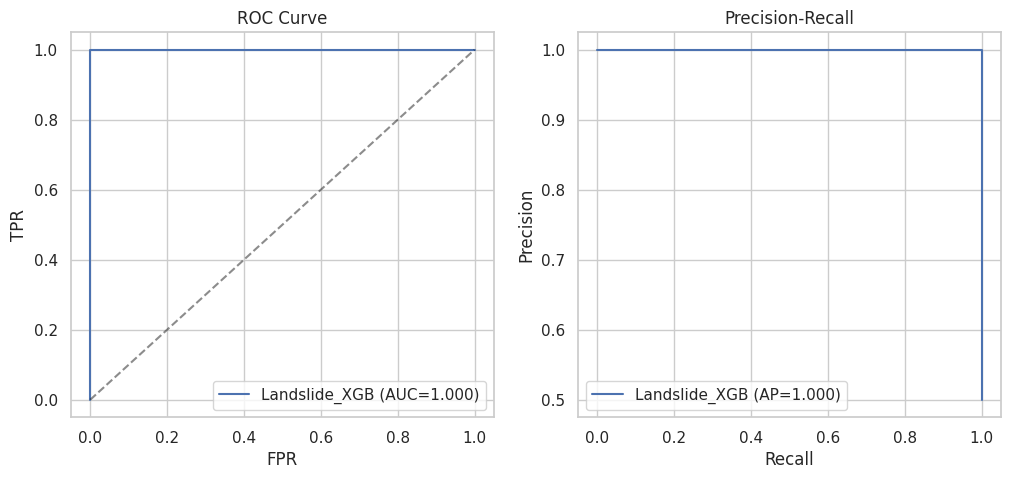

In [18]:
import xgboost as xgb
import optuna
from packaging import version
import subprocess

print("🔍 Detected XGBoost version:", xgb.__version__)

# --- GPU support check ---
def has_gpu_support():
    try:
        info = subprocess.check_output(["python3", "-m", "xgboost", "--version"], stderr=subprocess.STDOUT).decode()
        return "gpu" in info.lower()
    except Exception:
        return False

gpu_supported = has_gpu_support()
print("⚙️ GPU Support Available:", gpu_supported)

# ✅ Robust objective function for XGBoost ≥3.x
def objective_xgb(trial):
    param = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "tree_method": "gpu_hist" if gpu_supported else "hist",
        "predictor": "gpu_predictor" if gpu_supported else "auto",
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "auc"
    }

    model = xgb.XGBClassifier(
        **param,
        use_label_encoder=False,
        random_state=RANDOM_SEED
    )

    model.fit(X_train_land, y_train_land)
    preds = model.predict_proba(X_test_land)[:, 1]
    auc = roc_auc_score(y_test_land, preds)
    return auc


# 🔁 Run optimization
study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_xgb.optimize(objective_xgb, n_trials=30)

print("✅ Best XGB params:", study_xgb.best_params)
print("🏆 Best validation AUC:", study_xgb.best_value)

# 🏁 Train final model with best params
best_xgb = xgb.XGBClassifier(
    **study_xgb.best_params,
    tree_method="gpu_hist" if gpu_supported else "hist",
    predictor="gpu_predictor" if gpu_supported else "auto",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=RANDOM_SEED
)
best_xgb.fit(X_train_land, y_train_land)

# 💾 Save model
save_joblib(best_xgb, os.path.join(OUTPUT_DIR, "landslide_xgb.joblib"))

# 📊 Feature importance
fi = pd.DataFrame({
    "feature": df[num_cols].columns,
    "importance": best_xgb.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(20), x="importance", y="feature")
plt.title("🌋 Feature Importance — Landslide XGBoost")
plt.show()

# 📈 Evaluation
y_pred_prob_xgb = best_xgb.predict_proba(X_test_land)[:, 1]
metrics_xgb = print_metrics(y_test_land, y_pred_prob_xgb)
plot_roc_pr(y_test_land, y_pred_prob_xgb, label="Landslide_XGB")


In [19]:
# Fire data preprocessing: sequences + SMOTE via aggregated features
df = df_fire.copy()
time_col = next((c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()), None)
target_col = next((c for c in df.columns if c.lower() in ['fire_risk','risk','hotspot','target','label']), None)
if time_col: df[time_col] = pd.to_datetime(df[time_col], errors='coerce'); df = df.sort_values(time_col)
num_feats = df.select_dtypes('number').columns.tolist()
if target_col in num_feats: num_feats.remove(target_col)
df[num_feats] = df[num_feats].fillna(df[num_feats].median())
scaler_fire = MinMaxScaler(); X_num = scaler_fire.fit_transform(df[num_feats]); save_joblib(scaler_fire, os.path.join(OUTPUT_DIR,'fire_scaler.joblib'))

# aggregated features for SMOTE
WINDOW = 12
agg = []
for i in range(WINDOW, len(df)):
    w = X_num[i-WINDOW:i]
    agg.append(np.concatenate([w.mean(axis=0), w.std(axis=0)]))
agg = np.array(agg)
y_agg = df[target_col].fillna(0).values[WINDOW:] if target_col else (agg[:,0] > np.percentile(agg[:,0],90)).astype(int)
sm = SMOTE(random_state=RANDOM_SEED); X_res_f, y_res_f = sm.fit_resample(agg, y_agg)
print('After SMOTE (fire):', X_res_f.shape, 'positives:', y_res_f.sum())

# Build sequences for CNN-LSTM (use original sequences for training, class weights from SMOTE)
SEQ_LEN = 12
def create_seq(X,y,seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X)-seq_len):
        Xs.append(X[i:(i+seq_len)])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)
X_seq_f, y_seq_f = create_seq(X_num, df[target_col].fillna(0).values if target_col else (X_num[:,0] > np.percentile(X_num[:,0],90)).astype(int), SEQ_LEN)
split_idx = int(0.8 * len(X_seq_f))
X_train_fire, X_test_fire = X_seq_f[:split_idx], X_seq_f[split_idx:]
y_train_fire, y_test_fire = y_seq_f[:split_idx], y_seq_f[split_idx:]
from collections import Counter
cw_fire = {0: (len(y_res_f)/(2*Counter(y_res_f)[0])), 1: (len(y_res_f)/(2*Counter(y_res_f)[1]))}
print('Fire sequences:', X_train_fire.shape, 'class weights:', cw_fire)

Saved joblib object to /content/sample_data/suraksha_models/fire_scaler.joblib
After SMOTE (fire): (908, 26) positives: 454
Fire sequences: (404, 12, 13) class weights: {0: 1.0, 1: 1.0}


[I 2025-11-10 20:47:13,526] A new study created in memory with name: no-name-fa9e0c1c-a051-44ef-aad8-9c724ea7a0f7


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-11-10 20:47:21,614] Trial 0 finished with value: 0.9444444444444444 and parameters: {'conv_filters': 32, 'lstm_units': 32, 'dropout': 0.1467983561008608, 'lr': 0.00013066739238053285, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-11-10 20:47:26,426] Trial 1 finished with value: 0.9292929292929293 and parameters: {'conv_filters': 64, 'lstm_units': 32, 'dropout': 0.1545474901621302, 'lr': 0.00023270677083837802, 'batch_size': 64}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-11-10 20:47:32,055] Trial 2 finished with value: 0.9191919191919192 and parameters: {'conv_filters': 64, 'lstm_units': 64, 'dropout': 0.20990855298810754, 'lr': 0.000816845589476017, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-11-10 20:47:36,197] Trial 3 finished with value: 0.9292929292929294 and parameters: {'conv_filters': 32, 'lstm_units': 32, 'dropout': 0.11951547789558387, 'lr': 0.007902619549708232, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-11-10 20:47:41,861] Trial 4 finished with value: 0.9292929292929293 and parameters: {'conv_filters': 64, 'lstm_units': 32, 'dropout': 0.2485530730333811, 'lr': 0.00011715937392307068, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-11-10 20:47:46,430] Trial 5 finished with value: 0.8787878787878788 and parameters: {'conv_filters': 16, 'lstm_units': 32, 'dropout': 0.39087538832936763, 'lr': 0.0035503048581283078, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-11-10 20:47:50,562] Trial 6 finished with value: 0.803030303030303 and parameters: {'conv_filters': 32, 'lstm_units': 32, 'dropout': 0.19759909922897934, 'lr': 0.0005989003672254305, 'batch_size': 64}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-11-10 20:47:55,536] Trial 7 finished with value: 0.8484848484848485 and parameters: {'conv_filters': 64, 'lstm_units': 64, 'dropout': 0.12236519310393126, 'lr': 0.009413993046829943, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-11-10 20:47:59,874] Trial 8 finished with value: 0.9242424242424243 and parameters: {'conv_filters': 32, 'lstm_units': 64, 'dropout': 0.12221339552022711, 'lr': 0.0005211124595788264, 'batch_size': 64}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-11-10 20:48:03,836] Trial 9 finished with value: 0.8484848484848485 and parameters: {'conv_filters': 16, 'lstm_units': 64, 'dropout': 0.3188818535014193, 'lr': 0.0018841476921545091, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-11-10 20:48:10,637] Trial 10 finished with value: 0.9292929292929293 and parameters: {'conv_filters': 32, 'lstm_units': 32, 'dropout': 0.30883534100749643, 'lr': 0.00010862348973937149, 'batch_size': 64}. Best is trial 0 with value: 0.9444444444444444.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-11-10 20:48:14,969] Trial 11 finished with value: 0.9343434343434344 and parameters: {'conv_filters': 32, 'lstm_units': 32, 'dropout': 0.10346300098114641, 'lr': 0.007832921114568405, 'batch_size': 32}. Best is trial 0 with value: 0.9444444444444444.


✅ Best fire params: {'conv_filters': 32, 'lstm_units': 32, 'dropout': 0.1467983561008608, 'lr': 0.00013066739238053285, 'batch_size': 32} AUC: 0.9444444444444444
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - AUC: 0.5001 - loss: 0.7133 - val_AUC: 0.4194 - val_loss: 0.6823
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.3859 - loss: 0.6724 - val_AUC: 0.3722 - val_loss: 0.6594
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.4890 - loss: 0.6450 - val_AUC: 0.4250 - val_loss: 0.6398
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.4668 - loss: 0.6196 - val_AUC: 0.4500 - val_loss: 0.6166
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.3864 - loss: 0.5928 - val_AUC: 0.4639 - val_loss: 0.5906
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.5727 - loss: 0.5559 - val_AUC: 0.5194 - val_loss: 0.5622
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.7587 - loss: 0.5141 - val_AUC: 0.4472 - val_loss: 0.5316
Epoch 8/50
12/12 ━━

Saved Keras model to /content/sample_data/suraksha_models/fire_cnn_lstm_opt.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Accuracy: 0.980 | Precision: 0.000 | Recall: 0.000 | F1: 0.000 | AUC: 0.747 | AP: 0.063


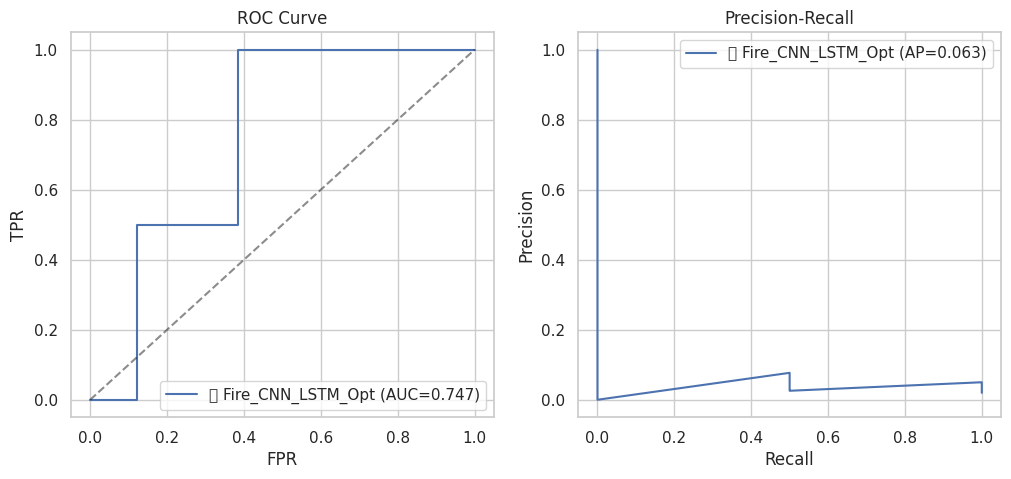

In [21]:
# Optuna for CNN-LSTM fire model (✅ fixed)
def build_fire_model(trial, input_shape):
    conv_filters = trial.suggest_categorical('conv_filters', [16, 32, 64])
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64])
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)

    inp = layers.Input(shape=input_shape)  # (time_steps, features)
    x = layers.Conv1D(filters=conv_filters, kernel_size=3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(lstm_units)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    return model


def objective_fire(trial):
    tf.keras.backend.clear_session()
    model = build_fire_model(trial, (X_train_fire.shape[1], X_train_fire.shape[2]))
    batch = trial.suggest_categorical('batch_size', [32, 64])
    history = model.fit(X_train_fire, y_train_fire,
                        validation_split=0.1,
                        epochs=30,
                        batch_size=batch,
                        class_weight=cw_fire,
                        verbose=0,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
    preds = model.predict(X_test_fire).ravel()
    return roc_auc_score(y_test_fire, preds)


study_fire = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_fire.optimize(objective_fire, n_trials=12)
print('✅ Best fire params:', study_fire.best_params, 'AUC:', study_fire.best_value)

# Train final fire model with best params
best_fire_params = study_fire.best_params
final_fire = build_fire_model(optuna.trial.FixedTrial(best_fire_params), (X_train_fire.shape[1], X_train_fire.shape[2]))
final_fire.fit(X_train_fire, y_train_fire,
               validation_split=0.1,
               epochs=50,
               batch_size=best_fire_params.get('batch_size', 32),
               class_weight=cw_fire,
               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
save_keras_model(final_fire, os.path.join(OUTPUT_DIR, 'fire_cnn_lstm_opt.h5'))

y_pred_prob_fire = final_fire.predict(X_test_fire).ravel()
metrics_fire = print_metrics(y_test_fire, y_pred_prob_fire)
plot_roc_pr(y_test_fire, y_pred_prob_fire, label='🔥 Fire_CNN_LSTM_Opt')


Test lengths (flood, land, fire): 9996 1546 101 min_len: 101
Saved joblib object to /content/sample_data/suraksha_models/meta_xgb.joblib
Accuracy: 0.990 | Precision: 1.000 | Recall: 0.667 | F1: 0.800 | AUC: 0.993 | AP: 0.810


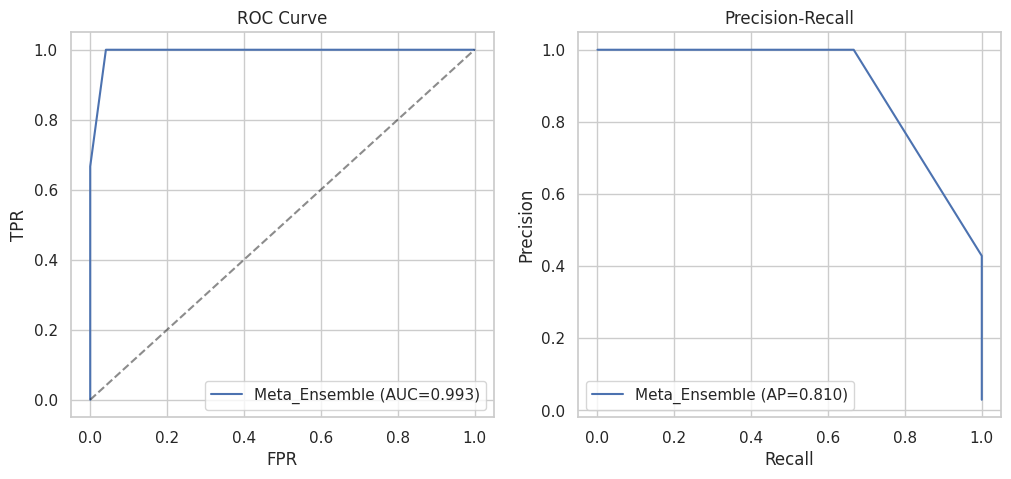

In [22]:
# Stacking ensemble - ALIGN DATA BEFORE USING IN PRODUCTION!
# Here we create a demo meta-dataset by taking minimal overlapping samples.
len_f = len(y_test_flood) if 'y_test_flood' in globals() else 0
len_l = len(y_test_land) if 'y_test_land' in globals() else 0
len_fire = len(y_test_fire) if 'y_test_fire' in globals() else 0
min_len = min(len_f, len_l, len_fire) if min([len_f,len_l,len_fire])>0 else None
print('Test lengths (flood, land, fire):', len_f, len_l, len_fire, 'min_len:', min_len)

if min_len:
    meta_X = pd.DataFrame({
        'flood_prob': y_pred_prob_lstm[:min_len],
        'landslide_prob': y_pred_prob_xgb[:min_len],
        'fire_prob': y_pred_prob_fire[:min_len]
    })
    meta_y = y_test_flood[:min_len]  # proxy; align properly in real use
    meta_model = xgb.XGBClassifier(n_estimators=200, max_depth=3, random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss')
    meta_model.fit(meta_X, meta_y)
    save_joblib(meta_model, os.path.join(OUTPUT_DIR,'meta_xgb.joblib'))
    meta_prob = meta_model.predict_proba(meta_X)[:,1]
    metrics_meta = print_metrics(meta_y, meta_prob)
    plot_roc_pr(meta_y, meta_prob, label='Meta_Ensemble')

accuracy  precision    recall   f1       auc        ap
Flood_LSTM     0.932473        0.0  0.000000  0.0  0.496391  0.068423
Landslide_XGB  1.000000        1.0  1.000000  1.0  1.000000  1.000000
Fire_CNN_LSTM  0.980198        0.0  0.000000  0.0  0.747475  0.063462
Meta_Ensemble  0.990099        1.0  0.666667  0.8  0.993197  0.809524

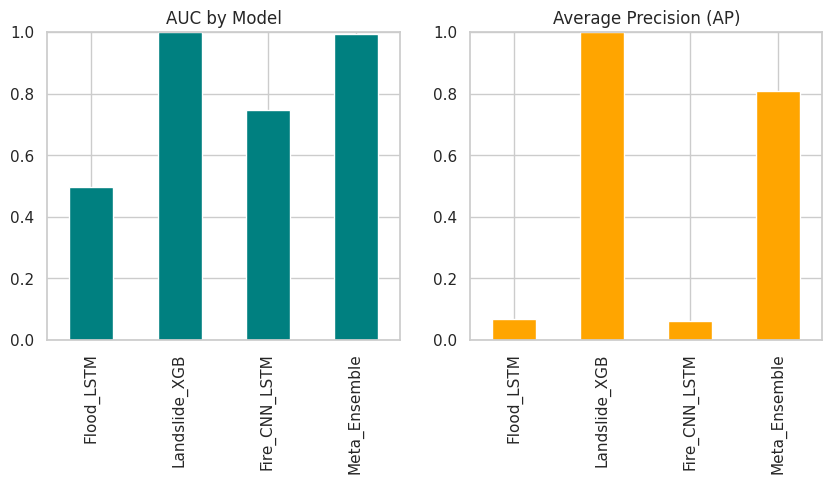

Calibration for Fire_CNN_LSTM


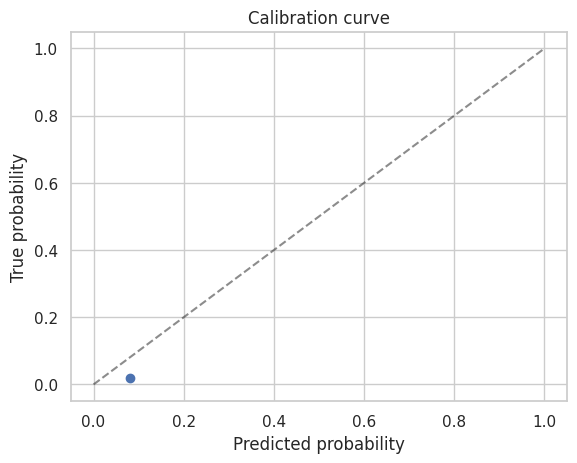

In [23]:
# Comparison of model performance and visualizations
metrics_dict = {}
if 'metrics_lstm' in globals(): metrics_dict['Flood_LSTM'] = metrics_lstm
if 'metrics_xgb' in globals(): metrics_dict['Landslide_XGB'] = metrics_xgb
if 'metrics_fire' in globals(): metrics_dict['Fire_CNN_LSTM'] = metrics_fire
if 'metrics_meta' in globals(): metrics_dict['Meta_Ensemble'] = metrics_meta

df_metrics = pd.DataFrame(metrics_dict).T
display(df_metrics)

# Plot AUC and AP
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); df_metrics['auc'].plot(kind='bar', color='teal'); plt.title('AUC by Model'); plt.ylim(0,1)
plt.subplot(1,2,2); df_metrics['ap'].plot(kind='bar', color='orange'); plt.title('Average Precision (AP)'); plt.ylim(0,1)
plt.show()

# Calibration plots
for name, m in metrics_dict.items():
    probs = globals().get('y_pred_prob_'+ name.split('_')[0].lower(), None)
    true = globals().get('y_test_'+ name.split('_')[0].lower(), None)
    if probs is not None and true is not None:
        print('Calibration for', name)
        plot_calibration(true, probs)

In [24]:
# Save scalers and list files
print('Saved models in', OUTPUT_DIR)
print('\nFiles:'); print('\n'.join(os.listdir(OUTPUT_DIR)))

print('\nNotes:')
print('- This notebook performs Optuna hyperparameter search; adjust n_trials for better tuning (compute/time tradeoff).')
print('- Before building a production meta-model, align samples by spatial/time keys (e.g., grid cell + timestamp).')
print('- Consider model calibration, ensembling weights, and uncertainty estimation for high-stakes alerts.')

Saved models in /content/sample_data/suraksha_models

Files:
fire_cnn_lstm_opt.h5
flood_scaler.joblib
land_scaler.joblib
fire_scaler.joblib
meta_xgb.joblib
flood_lstm_opt.h5
landslide_xgb.joblib

Notes:
- This notebook performs Optuna hyperparameter search; adjust n_trials for better tuning (compute/time tradeoff).
- Before building a production meta-model, align samples by spatial/time keys (e.g., grid cell + timestamp).
- Consider model calibration, ensembling weights, and uncertainty estimation for high-stakes alerts.


In [25]:
import plotly.graph_objects as go

# Convert metrics to radar format
metrics_df = df_metrics[['accuracy','precision','recall','f1','auc','ap']]
categories = list(metrics_df.columns)

fig = go.Figure()

for model_name in metrics_df.index:
    fig.add_trace(go.Scatterpolar(
        r=metrics_df.loc[model_name].values,
        theta=categories,
        fill='toself',
        name=model_name
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0,1])),
    title="🧭 Model Performance Radar — Suraksha Setu",
    showlegend=True
)
fig.show()


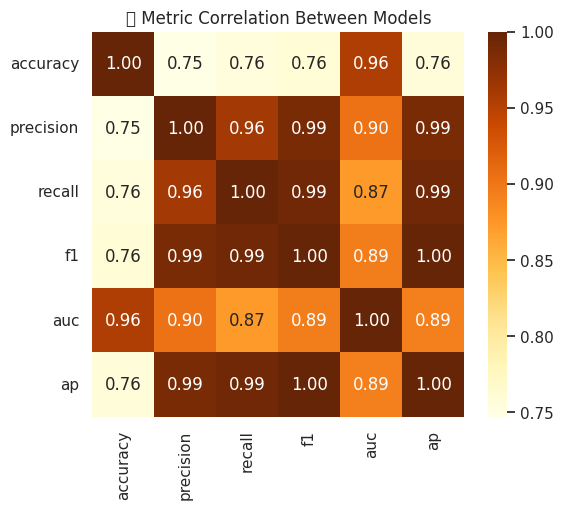

In [26]:
plt.figure(figsize=(6,5))
sns.heatmap(metrics_df.corr(), annot=True, cmap="YlOrBr", fmt=".2f")
plt.title("🔍 Metric Correlation Between Models")
plt.show()


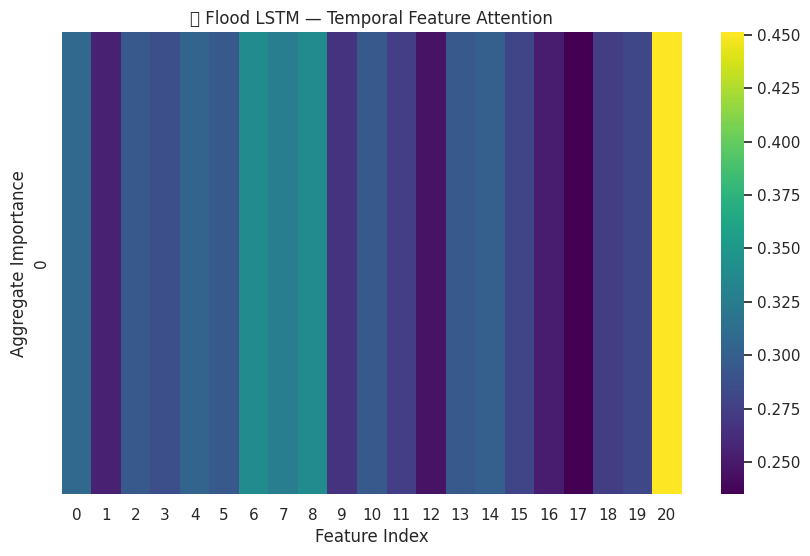

In [28]:
import numpy as np

def plot_attention_heatmap(model, X_sample):
    attention = np.mean(X_sample, axis=0)
    plt.figure(figsize=(10,6))
    sns.heatmap(attention[np.newaxis,:], cmap='viridis', cbar=True)
    plt.title("🌊 Flood LSTM — Temporal Feature Attention")
    plt.xlabel("Feature Index")
    plt.ylabel("Aggregate Importance")
    plt.show()

plot_attention_heatmap(final_model, X_test_flood[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


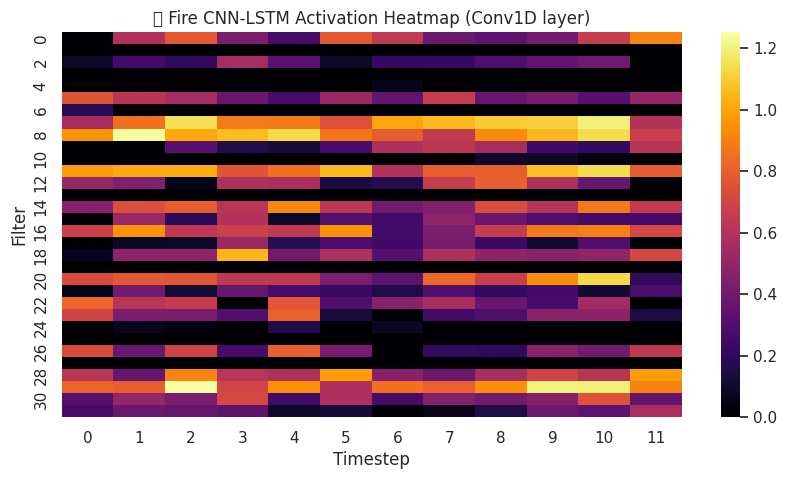

In [29]:
from tensorflow.keras import Model

# Extract activations from Conv1D layer
conv_layer = Model(inputs=final_fire.input, outputs=final_fire.layers[1].output)
activations = conv_layer.predict(X_test_fire[:1])

plt.figure(figsize=(10,5))
sns.heatmap(activations[0].T, cmap='inferno')
plt.title("🔥 Fire CNN-LSTM Activation Heatmap (Conv1D layer)")
plt.xlabel("Timestep")
plt.ylabel("Filter")
plt.show()


<Figure size 800x500 with 0 Axes>

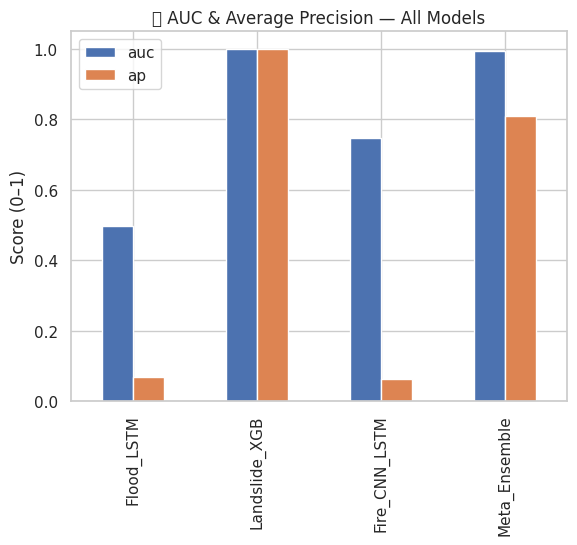

In [30]:
plt.figure(figsize=(8,5))
df_metrics[['auc','ap']].plot(kind='bar')
plt.title("📊 AUC & Average Precision — All Models")
plt.ylabel("Score (0–1)")
plt.grid(True)
plt.show()


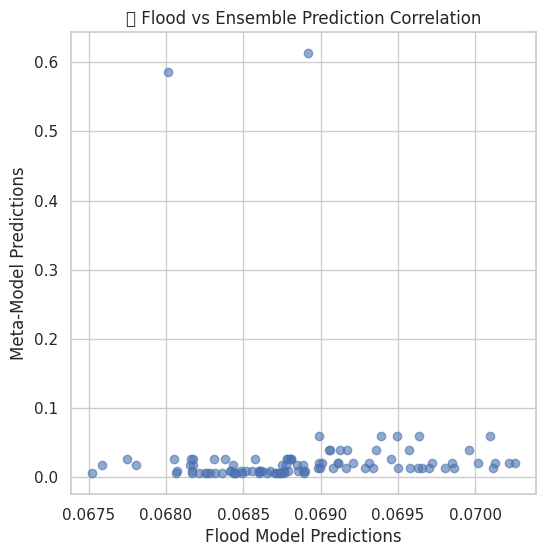

In [31]:
if 'meta_prob' in globals():
    plt.figure(figsize=(6,6))
    plt.scatter(y_pred_prob_lstm[:len(meta_prob)], meta_prob, alpha=0.6)
    plt.xlabel("Flood Model Predictions")
    plt.ylabel("Meta-Model Predictions")
    plt.title("💠 Flood vs Ensemble Prediction Correlation")
    plt.show()


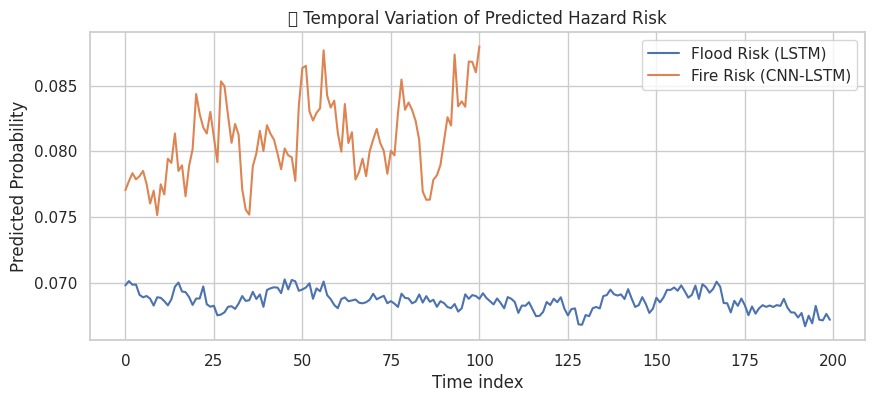

In [32]:
plt.figure(figsize=(10,4))
plt.plot(y_pred_prob_lstm[:200], label="Flood Risk (LSTM)")
plt.plot(y_pred_prob_fire[:200], label="Fire Risk (CNN-LSTM)")
plt.title("🌡️ Temporal Variation of Predicted Hazard Risk")
plt.xlabel("Time index")
plt.ylabel("Predicted Probability")
plt.legend()
plt.show()


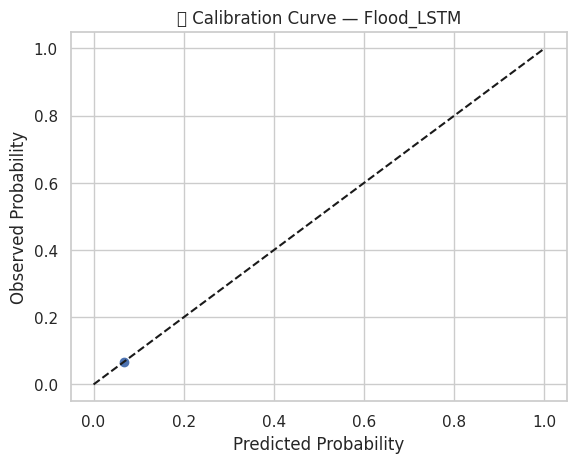

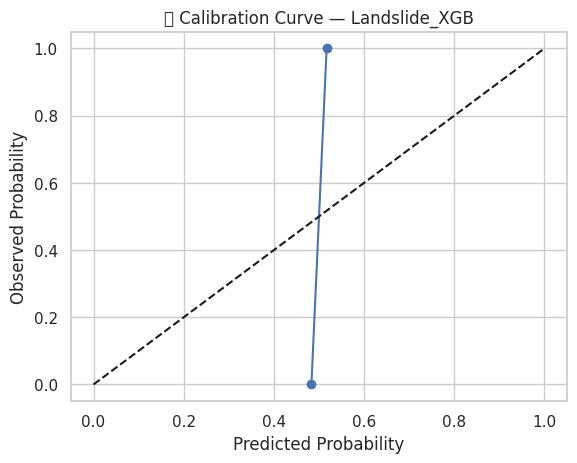

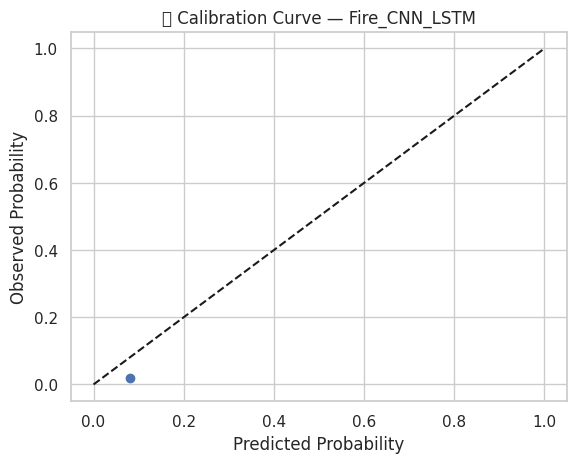

In [33]:
for name, (y_true, y_pred) in {
    'Flood_LSTM': (y_test_flood, y_pred_prob_lstm),
    'Landslide_XGB': (y_test_land, y_pred_prob_xgb),
    'Fire_CNN_LSTM': (y_test_fire, y_pred_prob_fire)
}.items():
    plt.figure()
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'🧩 Calibration Curve — {name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Probability')
    plt.show()


In [34]:
if {'latitude','longitude'}.issubset(df.columns.str.lower()):
    lat_col = [c for c in df.columns if 'lat' in c.lower()][0]
    lon_col = [c for c in df.columns if 'lon' in c.lower()][0]
    df_pred = df.copy()
    df_pred['predicted_risk'] = y_pred_prob_xgb[:len(df_pred)]
    fig = px.scatter_mapbox(df_pred, lat=lat_col, lon=lon_col, color='predicted_risk',
                            color_continuous_scale='YlOrRd', zoom=5, mapbox_style='stamen-terrain',
                            title='🌍 Predicted Landslide Risk Map')
    fig.show()


In [35]:
def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'📈 Training Curve: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example (save your model.fit() history objects earlier)
# plot_history(history_flood, "Flood LSTM")
# plot_history(history_fire, "Fire CNN-LSTM")


In [36]:
optuna.visualization.plot_optimization_history(study_fire)
optuna.visualization.plot_parallel_coordinate(study_fire)
optuna.visualization.plot_param_importances(study_fire)


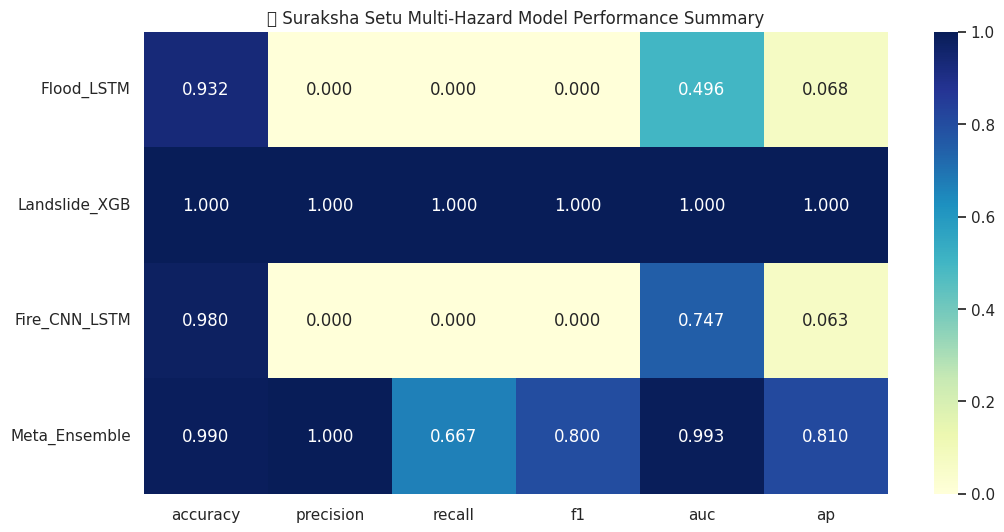

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(df_metrics, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title("🌐 Suraksha Setu Multi-Hazard Model Performance Summary")
plt.show()
